# Perovskite Solar Cells Dominant Recombination Classifier

## Introduction

One of the key challenge when optimizing a new solar cells is to know the key loss mecanism limiting the efficiency.The main losses in perovskite solar cells (PSCs) can be distinguished between 3 main categories: (1) band-to-band recombination, trap assited recombination in the bulk of the material (2) or at the interfaces (3). Here, we use Scikit-learn DecisionTreeClassifier and RandomForestClassifier to classify PSCs light-intensity dependent JV measurement output into these 3 different categories.

Import necessary packages


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns; sns.set()
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import StackingClassifier
from IPython.display import Image,display
from joblib import dump, load


Since it is not possible to gather enough experimental data to perform such a learning procedure we built our dataset using drift-diffusion simulation using open-source code SIMsalabim (https://github.com/kostergroup/SIMsalabim).

In [2]:
# Load datasets:
dataset = pd.read_csv(r'balanced_dataset.csv')
# for i in range(4):
#    dataset = pd.concat([dataset,pd.read_csv(r'dataset'+str(i+2)+'.csv')])
number_of_label = 3 
Gfrac = pd.read_csv(r'Gfrac_vector.csv')
Gfrac = Gfrac['0'].tolist()
# shuffle dataset to ensure randomness
dataset = dataset.sample(frac=1).reset_index(drop=True)
print('Size of Dataset {}'.format(len(dataset)))  
dataset = dataset.drop_duplicates()
print('Size of Dataset after dropping duplicates {}'.format(len(dataset)))  
target = dataset['label']

Size of Dataset 2470491
Size of Dataset after dropping duplicates 2470491


Note that the dataset saved in .csv format consist of over $2 \times 10^6$ simulated perovskite solar cells with their performance ($V_{OC}$,$J_{SC}$ and $FF$) at (0.1,0.18,032,0.56,1) sun illuminations as well as the ideality factor ($n$).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.25, random_state=42)

#### Selected features names
names = ['n','doping_left','doping_right', "mob_IL", "mob_IR", "mun_0", "mup_0",'Voc1.00','Jsc1.00','FF1.00']
for i in Gfrac:
    if i<1: names.append('Voc'+'%.2f' % i)
for i in Gfrac:
    if i<1: names.append('Jsc'+'%.2f' % i)
for i in Gfrac:
    if i<1: names.append('FF'+'%.2f' % i)
labels = ['Band-to-Band','GB','Interface']
print('List of the selected features for the learning:')
print(names)

List of the selected features for the learning:
['n', 'doping_left', 'doping_right', 'mob_IL', 'mob_IR', 'mun_0', 'mup_0', 'Voc1.00', 'Jsc1.00', 'FF1.00', 'Voc0.10', 'Voc0.18', 'Voc0.32', 'Voc0.56', 'Jsc0.10', 'Jsc0.18', 'Jsc0.32', 'Jsc0.56', 'FF0.10', 'FF0.18', 'FF0.32', 'FF0.56']


Select classifiers:

In [4]:
# Uncomment the wanted classifier
max_depth_tree = None
max_depth_forest = None
n_estimators_forest = 1000
classifiers = [
    ('Decision Tree', tree.DecisionTreeClassifier(max_depth=max_depth_tree)),
    ('Random Forest', RandomForestClassifier(n_estimators=n_estimators_forest,max_depth=max_depth_tree,n_jobs=-1)),
    # ('Nearest Neighbors', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)),
    # ('Neural Network', MLPClassifier())
    # ('AdaBoost',AdaBoostClassifier()),
    # ('Naive Bayes',GaussianNB()),
    # ('QDA',QuadraticDiscriminantAnalysis())
]
# stacking_classifier = StackingClassifier(estimators=classifiers)

X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.25, random_state=42)

Start training:

In [5]:
idx = 0
make_full_report = False
for (clf_name, clf) in classifiers: # +[('Stacked classifiers',stacking_classifier)]:
    
    print('\n\nTraining '+clf_name)
    start_time = time.time()
    clf.fit(X_train[names], y_train)
    elapsed_time = time.time() - start_time
    print('Trained in {:.2f} seconds'.format(elapsed_time))
    
    dump(clf,clf_name+'.joblib') # save clf

    if type(clf) == type(tree.DecisionTreeClassifier()):
        clf_tree = pickle.dumps(clf)
         

    if type(clf) == type(RandomForestClassifier()):
        clf_forest = pickle.dumps(clf)
    
    if make_full_report:
        print(metrics.classification_report(y_pred, y_test))
        mat = confusion_matrix(y_test, y_pred, normalize='pred')
        sns.heatmap(mat.T, square=True, annot=True, cmap=plt.cm.Blues, cbar=True,xticklabels=labels,\
        yticklabels=labels)
        plt.title('Normalized confusion matrix prediction '+clf_name)
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.show()
        print('-----------------------------------------')



Training Decision Tree
Trained in 71.15 seconds


Training Random Forest
Trained in 348.01 seconds


## Decision Tree

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    205329
         1.0       0.67      0.67      0.67    205080
         2.0       0.63      0.63      0.63    207214

    accuracy                           0.75    617623
   macro avg       0.75      0.75      0.75    617623
weighted avg       0.75      0.75      0.75    617623



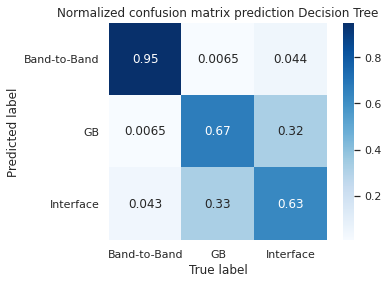

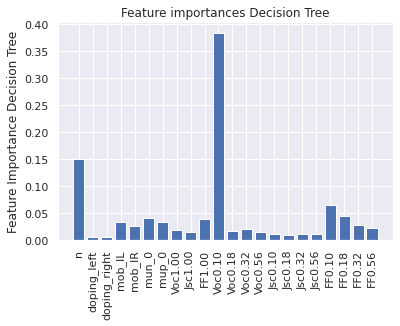

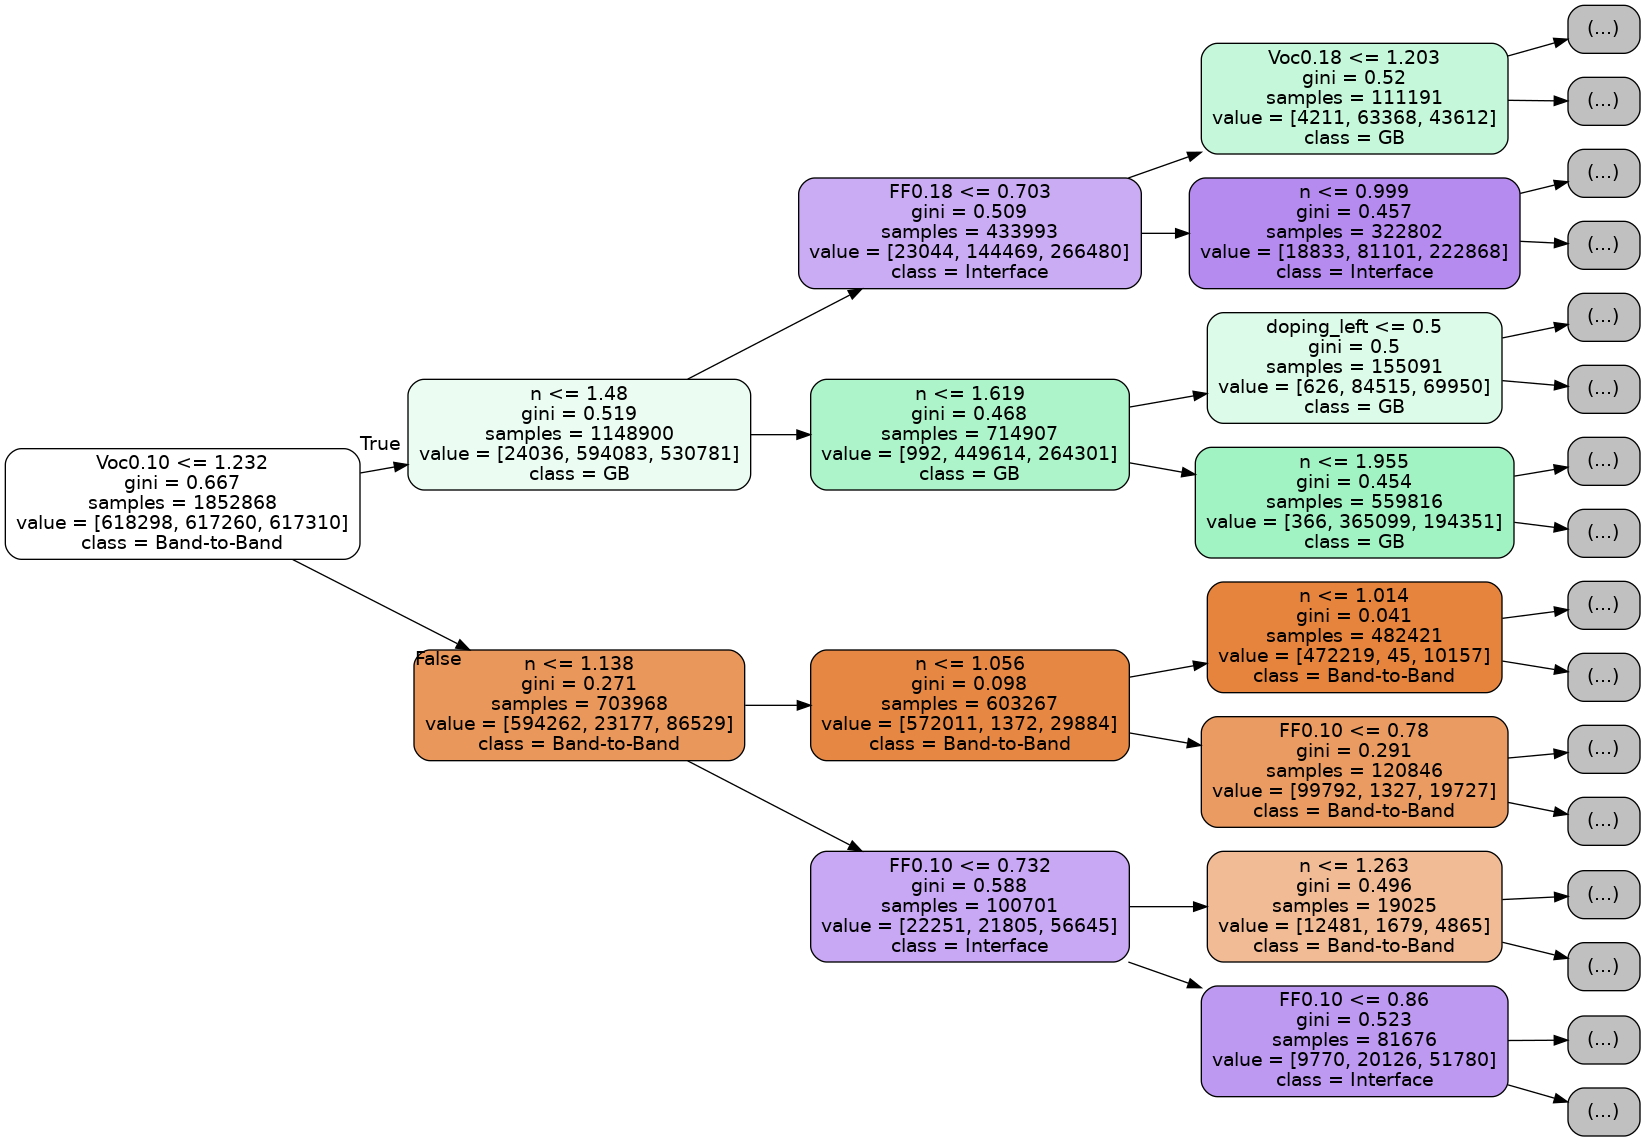

In [6]:
plot_tree = True
if plot_tree:
    clf = load('Decision Tree.joblib') # To load best tree ==> use Trained Decision Tree VLC.joblib
    if type(clf) == type(tree.DecisionTreeClassifier()):
        y_pred = clf.predict(X_test[names])
        print(metrics.classification_report(y_pred, y_test))
        mat = confusion_matrix(y_test, y_pred, normalize='pred')
        sns.heatmap(mat.T, square=True, annot=True, cmap=plt.cm.Blues, cbar=True,xticklabels=labels,\
        yticklabels=labels)
        plt.title('Normalized confusion matrix prediction Decision Tree')
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.show()

        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        plt.title('Feature importances Decision Tree')
        plt.bar(names,clf.feature_importances_)
        plt.ylabel('Feature Importance Decision Tree')
        xtickNames = ax.set_xticklabels(names)
        plt.setp(xtickNames, rotation=90)
        plt.show()
        tree.export_graphviz(clf,max_depth = 3,out_file="tree.dot",feature_names = names,class_names=labels,\
        filled = True,rounded=True,rotate=True)
        #Note : for this command to work graphviz package need to be installed
        !dot -Tpng tree.dot -o tree.png

        display(Image(filename='tree.png'))
        plt.show()
    else :
        print('/!\ Wrong type of Classifier!') 

    

## Random Forest

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97    208002
         1.0       0.84      0.73      0.78    238564
         2.0       0.65      0.78      0.71    171057

    accuracy                           0.82    617623
   macro avg       0.82      0.82      0.82    617623
weighted avg       0.83      0.82      0.82    617623



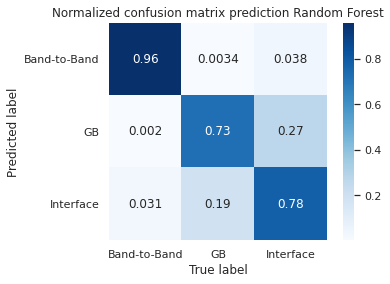

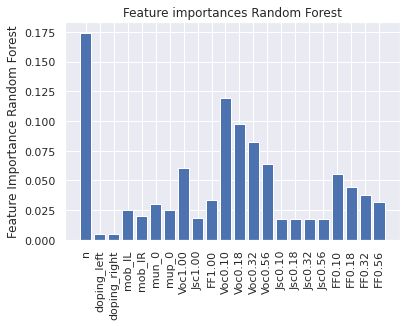

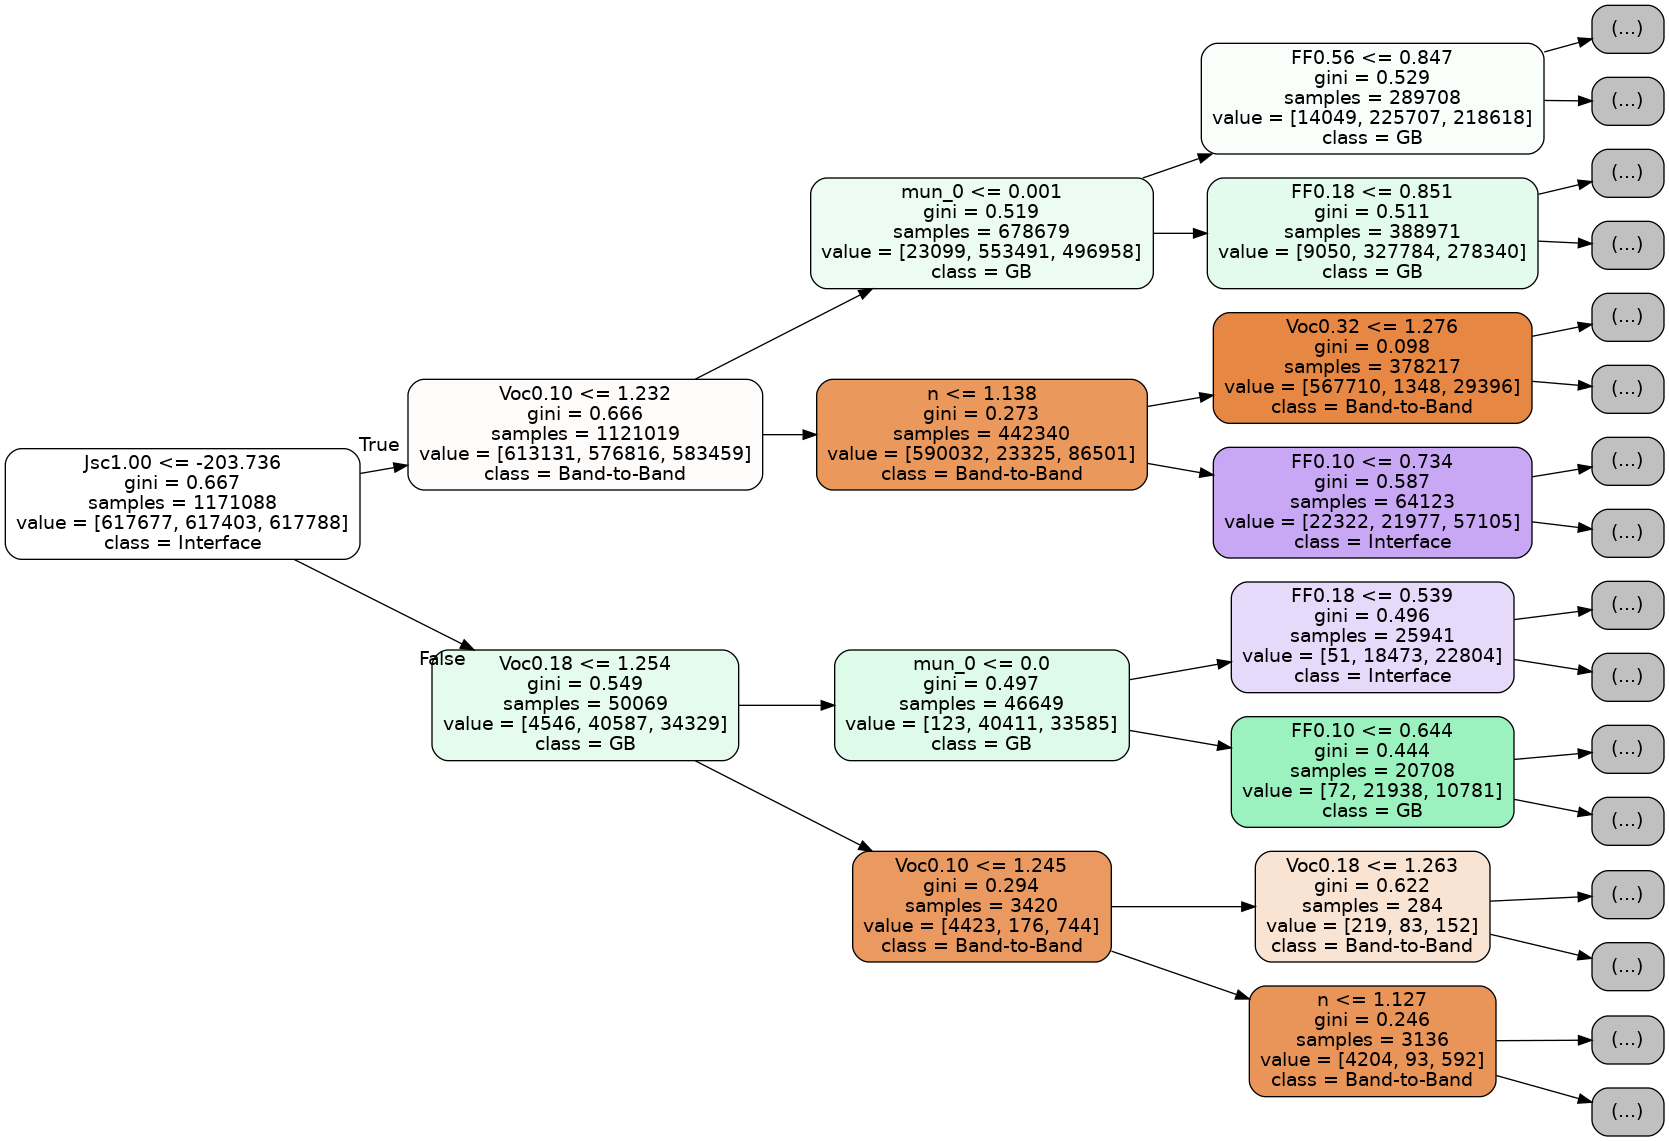

In [7]:
plot_forest = True
if plot_forest:
    clf = load('Random Forest.joblib') # To load best forest ==> use Trained Random Forest VLC.joblib
    if type(clf) == type(RandomForestClassifier()):
        y_pred = clf.predict(X_test[names])
        print(metrics.classification_report(y_pred, y_test))
        mat = confusion_matrix(y_test, y_pred, normalize='pred')
        sns.heatmap(mat.T, square=True, annot=True, cmap=plt.cm.Blues, cbar=True,xticklabels=labels,\
        yticklabels=labels)
        plt.title('Normalized confusion matrix prediction Random Forest')
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.show()

        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        plt.title('Feature importances Random Forest')
        plt.bar(names,clf.feature_importances_)
        plt.ylabel('Feature Importance Random Forest')
        xtickNames = ax.set_xticklabels(names)
        plt.setp(xtickNames, rotation=90)
        plt.show()

        tree_forest = clf.estimators_[5] # pick any number between 0 and n_estimators
        tree.export_graphviz(tree_forest,max_depth = 3,out_file="tree_forest.dot",feature_names = names,\
        class_names=labels,filled = True,rounded=True,rotate=True)
        #Note : for this command to work graphviz package need to be installed
        !dot -Tpng tree_forest.dot -o tree_forest.png

        display(Image(filename='tree_forest.png'))
        # plt.show() 